Suppose there is available only a finite amount of experience, say 10 episodes or 100
time steps. In this case, a common approach with incremental learning methods is to
present the experience repeatedly until the method converges upon an answer. Given an
approximate value function, V , the increments specified by (6.1) or (6.2) are computed
for every time step t at which a nonterminal state is visited, but the value function is
changed only once, by the sum of all the increments. Then all the available experience is
processed again with the new value function to produce a new overall increment, and so
on, until the value function converges. We call this batch updating because updates are
made only after processing each complete batch of training data.
Under batch updating, TD(0) converges deterministically to a single answer independent
of the step-size parameter, ↵, as long as ↵ is chosen to be suciently small. The constant-
↵ MC method also converges deterministically under the same conditions, but to a
di↵erent answer. Understanding these two answers will help us understand the di↵erence
between the two methods. Under normal updating the methods do not move all the way
to their respective batch answers, but in some sense they take steps in these directions.
Before trying to understand the two answers in general, for all possible tasks, we first
look at a few examples.

Example 6.3: Random walk under batch updating Batch-updating versions of
TD(0) and constant-↵ MC were applied as follows to the random walk prediction example
(Example 6.2). After each new episode, all episodes seen so far were treated as a batch.
They were repeatedly presented to the algorithm, either TD(0) or constant-↵ MC, with
↵ suciently small that the value function converged. The resulting value function was
then compared with v⇡, and the average root mean square error across the five states
(and across 100 independent repetitions of the whole experiment) was plotted to obtain
6.3. Optimality of TD(0) 127
the learning curves shown in Figure 6.2. Note that the batch TD method was consistently
better than the batch Monte Carlo method.
Under batch training, constant-↵
MC converges to values, V (s), that
are sample averages of the actual returns experienced after visiting each
state s. These are optimal estimates
in the sense that they minimize the
mean square error from the actual
returns in the training set. In this
sense it is surprising that the batch
TD method was able to perform
better according to the root mean
square error measure shown in the
figure to the right. How is it that
batch TD was able to perform better
than this optimal method? The answer is that the Monte Carlo method
is optimal only in a limited way, and
that TD is optimal in a way that is more relevant to predicting returns

![example 6.3](assets/6.3_example_6.3.png)

In [31]:
import random

TRUE_STATE_VALUES = {
    'A': 1/6,
    'B': 2/6,
    'C': 3/6,
    'D': 4/6,
    'E': 5/6
}

state_list = ['left_terminal', 'A', 'B', 'C', 'D', 'E', 'right_terminal']
terminal_states = ['left_terminal', 'right_terminal']

INITIAL_STATE = 'C'

def get_next_state(state, action):
    if action == 'left':
        return state_list[state_list.index(state) - 1]
    else:
        return state_list[state_list.index(state) + 1]

def get_action():
    if random.random() < 0.5:
        return 'right'
    else:
        return 'left'
    
def get_reward(state, action):
    if state == 'E' and action == 'right':
        return 1
    else:
        return 0

def generate_episode():
    episode = []
    state = INITIAL_STATE
    while state not in terminal_states:
        action = get_action()
        next_state = get_next_state(state, action)
        reward = get_reward(state, action)
        episode.append((state, reward))
        state = next_state
    return episode

print(generate_episode())

[('C', 0), ('B', 0), ('C', 0), ('D', 0), ('E', 1)]


In [32]:
import numpy as np

def update_state_values_td(state_values, episode, alpha):
    for i in range(len(episode)):
        state, reward = episode[i]
        if i == len(episode) - 1:
            next_state_value = 0
        else:
            next_state, _ = episode[i + 1]
            next_state_value = state_values[next_state]
        
        error = reward + next_state_value - state_values[state]
        state_values[state] += alpha * error
    return state_values

def update_state_values_mc(state_values, episode, alpha):
    total_return = 0
    for state, reward in reversed(episode):
        total_return += reward
        state_values[state] += alpha * (total_return - state_values[state])

    return state_values

def calculate_rms_error(state_values, true_state_values):
    rms_error = 0
    for key, value in true_state_values.items():
        rms_error += (value - state_values[key]) ** 2
    rms_error = rms_error / len(true_state_values)
    rms_error = rms_error ** 0.5
    return rms_error

def get_total_divergence(previous_state_values, state_values):
    total_divergence = 0
    for key, value in state_values.items():
        total_divergence += (value - previous_state_values[key]) ** 2
    return total_divergence

def run_batch_learning(alpha, update_function, runs=100, num_episodes=100):
    rms_errors_over_runs = []
    for _ in range(runs):
        state_values = {
            'A': .5,
            'B': .5,
            'C': .5,
            'D': .5,
            'E': .5,
        }

        rms_errors = []
        episodes = []
        for _ in range(num_episodes):
            episode = generate_episode()
            episodes.append(episode)
            previous_state_values = {
                'A': float('inf'),
                'B': float('inf'),
                'C': float('inf'),
                'D': float('inf'),
                'E': float('inf'),
            }
            epsilon = 0.000001
            while get_total_divergence(previous_state_values, state_values) > epsilon:
                previous_state_values = state_values.copy()
                for episode in episodes:
                    state_values = update_function(state_values, episode, alpha)
            rms_errors.append(calculate_rms_error(state_values, TRUE_STATE_VALUES))
        rms_errors_over_runs.append(rms_errors)

    average_rms_errors = np.mean(rms_errors_over_runs, axis=0)
    print(state_values)

    return average_rms_errors


{'A': 0.16987531157430585, 'B': 0.32137231396353455, 'C': 0.4893342289138162, 'D': 0.6943231419102925, 'E': 0.8750978667374024}
{'A': 0.08612881554848843, 'B': 0.28739885561499257, 'C': 0.4904387771364562, 'D': 0.6432944323068859, 'E': 0.7804338537477646}


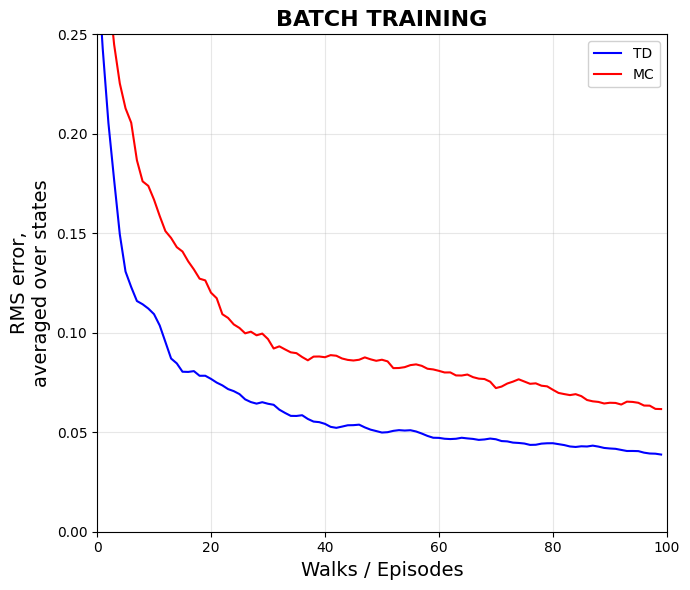

In [33]:
import matplotlib.pyplot as plt

alpha = 0.01
td_errors = run_batch_learning(alpha, update_state_values_td)
mc_errors = run_batch_learning(alpha, update_state_values_mc)

# Create figure with proper size   while get_total_divergence(previous_state_values, state_values) > epsilon:
plt.figure(figsize=(7, 6))

# TD lines (varied blue colors, thinner lines)
plt.plot(td_errors, color='blue', linestyle='-', linewidth=1.5, label='TD')
plt.plot(mc_errors, color='red', linestyle='-', linewidth=1.5, label='MC')

# Set axis limits and labels
plt.xlim(0, 100)
plt.ylim(0, 0.25)
plt.xlabel('Walks / Episodes', fontsize=14)
plt.ylabel('RMS error,\naveraged over states', fontsize=14)
plt.title('BATCH TRAINING', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Grid and styling
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()